In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb


# Evaluation


In [3]:
op = pd.read_csv('order_products__train.csv')
opp = pd.read_csv('order_products__prior.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
tips_tr = pd.read_csv('tip_trainingsdaten.csv', index_col=0)
tips_te = pd.read_csv('tip_testdaten.csv', index_col=0)

c:\Users\jdhau\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
instacart_train = tips_tr.merge(orders)
instacart_train.head()

,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,prior,1,2,8,NaN
1,2398795,1,1,prior,2,3,7,15.0
2,473747,1,1,prior,3,3,12,21.0
3,2254736,1,1,prior,4,4,7,29.0
4,431534,1,1,prior,5,4,15,28.0


In [5]:
instacart_train.eval_set.value_counts()

prior    3214874
Name: eval_set, dtype: int64

In [6]:
instacart_test = tips_te.merge(orders)
instacart_test.head()

,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1187899,NaN,1,train,11,4,8,14.0
1,1492625,NaN,2,train,15,1,11,30.0
2,2196797,NaN,5,train,5,0,11,6.0
3,525192,NaN,7,train,21,2,11,6.0
4,880375,NaN,8,train,4,1,14,10.0


In [7]:
instacart_test.eval_set.value_counts()

train    131209
Name: eval_set, dtype: int64

In [8]:
instacart_test['days_since_prior_order'].isna().sum()

0

# Business Understanding

In der Aufgaben geht es um einen Lieferdienst namens Instacart, bei dem Kunden Bestellungen aufgeben
können. Instacart schickt dann Fahrer los , die die Ware in
Supermärkten abholen und zum Kunden bringen. 
<br>
Dieser Datensatz enthält eine zusätzliche Spalte „Tip“, die zu den einzelnen
Bestellungen angibt, ob der Kunden beim Erhalt der Ware ein Trinkgeld gegeben hat oder nicht. Kern
der Aufgabe ist vorherzusagen, bei welchen Bestellungen Trinkgeld gegeben werden wird und bei
welchen nicht. 

### 1. Tip-Prediction
Es soll vorhergesagt werden, bei welchen Bestellungen die Kunden dem Fahrer Trinkgeld
gegeben werden und bei welchen nicht. Die Vorhersage kann dabei auf allen Informationen
basieren, die unmittelbar nach Aufgeben der Bestellung zur Verfügung stehen, d.h. alle
Daten zur aktuellen Bestellung sowie die gesamte Vorgeschichte. 
Zielerwartung sind mindestens 70% Genauigkeit bei der Vorhersage, ob ein Tip erfolgen wird oder nicht.

### 2. Analyse der Tip-Einflussfaktoren
Zusätzlich sollen auch interpretierbare Erkenntnisse geliefert werden, wovon es abhängt, ob
Trinkgeld gegeben wird. Diese sollen nachvollziehbar dargestellt werden. 

# Data Understanding

## Daten sammeln

- To-Do: Verknüpfung weiterer Daten zu den Bestellungen über Order-Products

## Beschreibung der Daten

- To-Do: Textuelle Beschreibung der Spalten

In [9]:
instacart_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214874 entries, 0 to 3214873
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   tip                     int64  
 2   user_id                 int64  
 3   eval_set                object 
 4   order_number            int64  
 5   order_dow               int64  
 6   order_hour_of_day       int64  
 7   days_since_prior_order  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 220.7+ MB


### order_id (int)
- Numerisches Features, welches für jede Bestellung eine einzigartige ID enthält.

### user_id (int)
- Numerisches Feature, welches für jeden distinkten Nutzer eine einzigeartige ID enthält.

### tip (int)
- Binäres Features mit der Information, ob ein Tip gebeben wurde. 0 bedeutet, dass kein Tip gegeben wurde, 1 bedeutet, dass ein Tip gegeben wurde.

### eval_set
- Kategorisches Features mit der Information zu welchem Set die Beobachtung gehört. Verfügbare Werte sind: train und test. Train kann für das Training benutzt werden. Für Test-Beobachtungen soll eine Vorhersage generiert werden.

### order_number
- Numerisches Features mit der Information, die wievielte Bestellung die des jeweiligen Nutzers die Beobachtung ist.

### order_dow
- Numerisches Features mit der Information über den Wochentag der Bestellung. Die Information ist als Zahl zwischen 0 und 6 encodiert. Es wird angenommen, dass die Tage 0 und 1 mit mehr Bestellungen die Tage Samstag und Sonntag sind. Die weiteren Tage sind in der üblichen Reihenfolge.

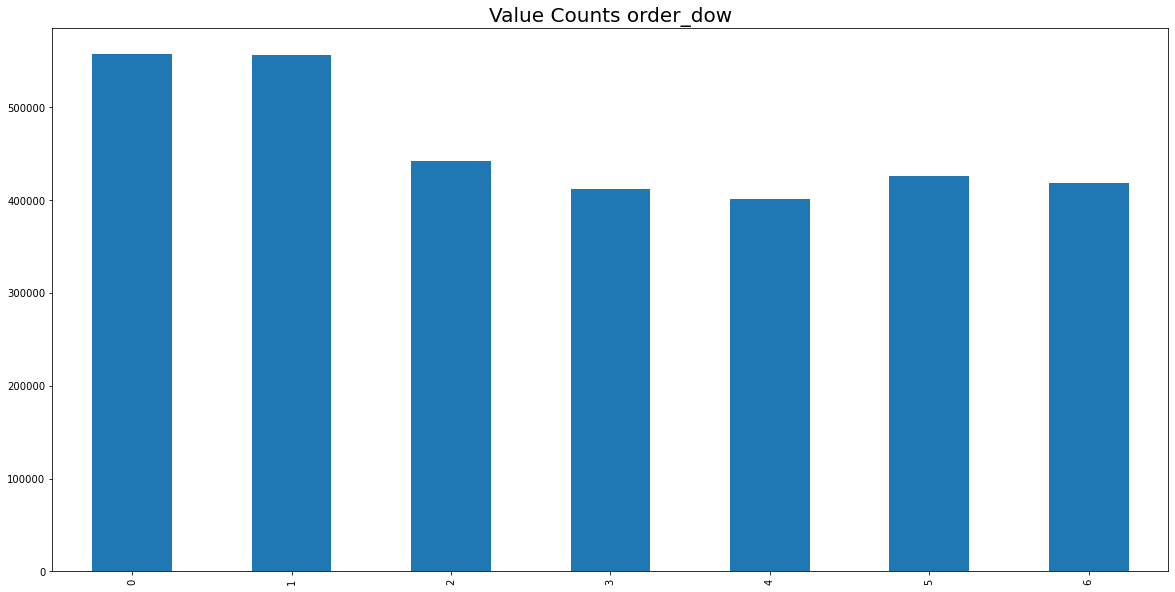

In [30]:
plt.figure(figsize=(20, 10))
ax = instacart_train['order_dow'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts order_dow', fontsize = 20)
plt.show()

### order_hour_of_day
- Numerisches Features mit der Information über die Uhrzeit der Bestellung.

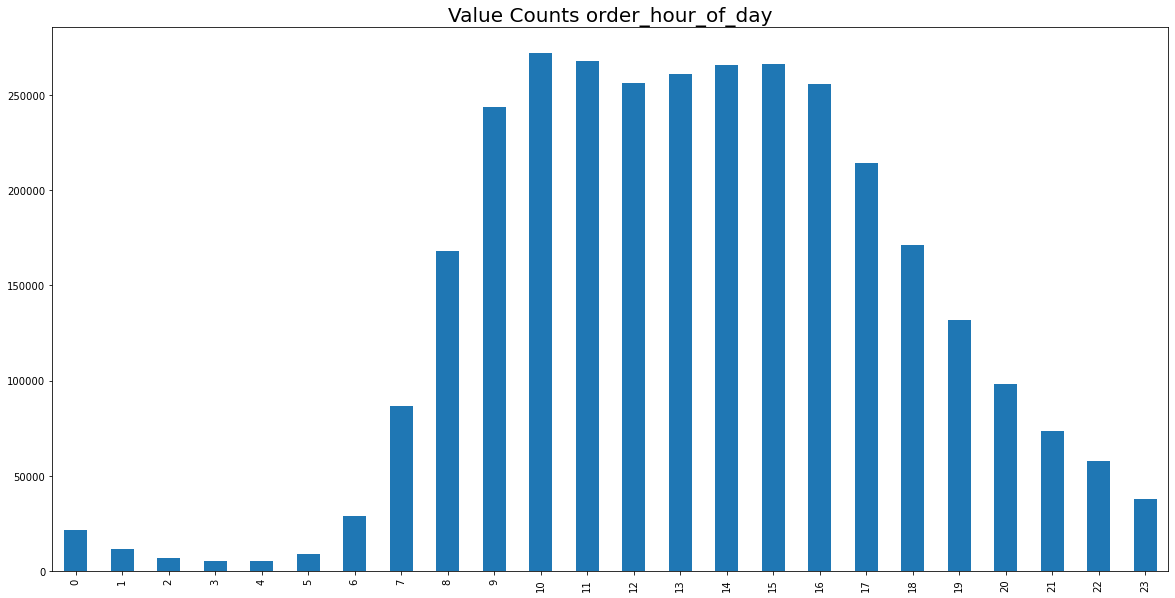

In [36]:
plt.figure(figsize=(20, 10))
ax = instacart_train['order_hour_of_day'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts order_hour_of_day', fontsize = 20)
plt.show()

### days_since_prior_order
- Numerisches Feature mit der Information über die Anzahl der vergangengen Tage seit der letzten seit der letzten Bestellung.

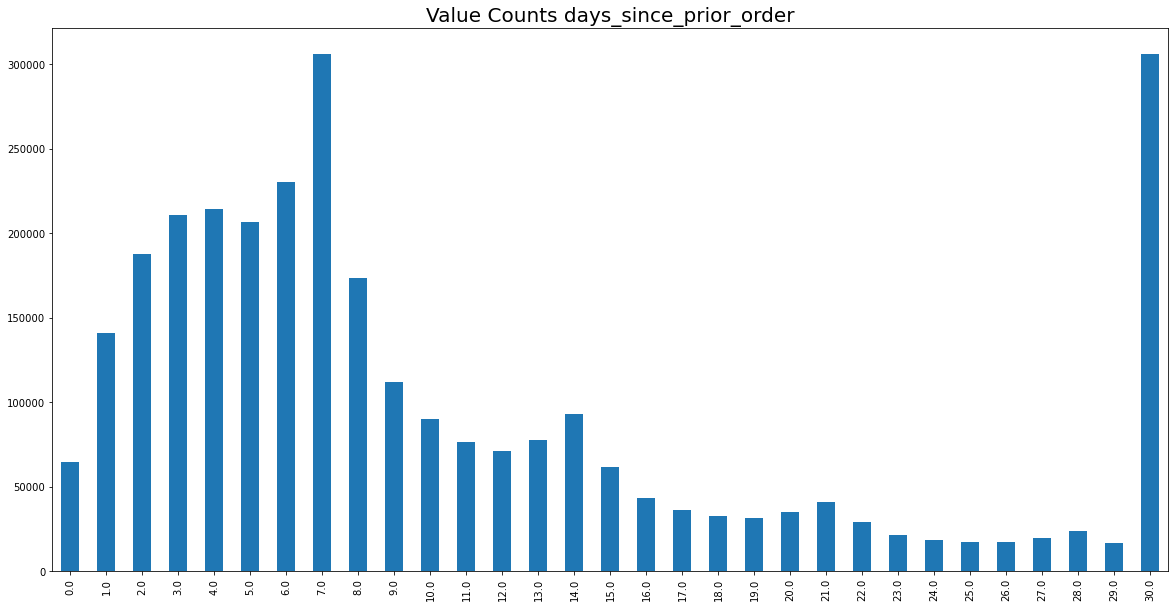

In [35]:
plt.figure(figsize=(20, 10))
ax = instacart_train['days_since_prior_order'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Value Counts days_since_prior_order', fontsize = 20)
plt.show()

Der Instacart Datensatz besteht aus über 3.2 Millionen Bestellungen. Die Daten pro Bestellung sind vollständig, bis auf den Wochentag der Bestellung (order_dow), bei dem Werte mit nan angegeben sind und was später ersetzt werden wird. Alle Daten sind ganzzahlige Werte (int), außer days_since_prior_order, welches ein Kommazahlenwert (float) ist. Eine weitere Ausnahme ist das Objekt eval_set. 

In [10]:
print('Description of instacart_train: ', instacart_train.shape)
instacart_train.head(10)

Description of instacart_train:  (3214874, 8)


,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,prior,1,2,8,NaN
1,2398795,1,1,prior,2,3,7,15.0
2,473747,1,1,prior,3,3,12,21.0
3,2254736,1,1,prior,4,4,7,29.0
4,431534,1,1,prior,5,4,15,28.0
5,3367565,1,1,prior,6,2,7,19.0
6,550135,1,1,prior,7,1,9,20.0
7,3108588,1,1,prior,8,1,14,14.0
8,2295261,1,1,prior,9,1,16,0.0
9,2550362,1,1,prior,10,4,8,30.0


In [11]:
instacart_train.isna().sum()


order_id                       0
tip                            0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

Welche verschiedenen Werte gibt es und wie oft kommen sie vor?
Um einen Überblick über die Bereitschaft zum Trinkgeld zu bekommen, wir geprüft, wieviele Personen bei den Bestellungen des Datensates Tringeld gegeben haben.
Bei circa 1.9 Millionen Bestellungen wurde Trinkgeld gegeben, bei 1.4 Millionen nicht. 

In [12]:
instacart_train['tip'].value_counts()

0    1858960
1    1355914
Name: tip, dtype: int64

Es haben circa 200.000 Personen bestellt.

In [13]:
instacart_train['user_id'].nunique()

206209

In [14]:
instacart_train.user_id.value_counts()

152340    99
185641    99
185524    99
81678     99
70922     99
          ..
13046      3
70208      3
111440     3
31762      3
47980      3
Name: user_id, Length: 206209, dtype: int64

Jede Person hat mindestens 3 Mal und maximal 99 Mal bestellt. Durchschnittlich hat jede Person 17 Bestellungen aufgegeben. 

TODO bitte kurz mal drüber schauen

In [15]:
instacart_train.order_number.value_counts()

1     206209
2     206209
3     206209
4     182223
5     162633
       ...  
95      1592
96      1525
97      1471
98      1421
99      1374
Name: order_number, Length: 99, dtype: int64

In [16]:
instacart_train.order_number.mean()

17.191065652961825

Alle Bestellungen im Testdatensatz gehören zum eval_set prio. 

TODO eval_set Spalte löschen, weil sie keine Informationen gibt? 

In [17]:
instacart_train.eval_set.value_counts()

prior    3214874
Name: eval_set, dtype: int64

Besonders oft wird an den Tagen mit der id 0 und 1 bestellt, am wenigsten an Tag 4.

TODO Tag durch Namen statt numerisches Attribut ersetzen

In [18]:
instacart_train.order_dow.value_counts().sort_index()


0    557772
1    556705
2    441955
3    412400
4    401212
5    425982
6    418848
Name: order_dow, dtype: int64

Die wenigsten Bestellungen gehen rund um 3 Uhr nachts ein, die meisten um 10 Uhr vormittags. 

In [19]:
instacart_train.order_hour_of_day.value_counts().sort_index()

0      21372
1      11596
2       7070
3       5120
4       5175
5       8972
6      28792
7      86656
8     168321
9     243496
10    271885
11    268006
12    256206
13    261174
14    265556
15    266132
16    255949
17    214080
18    170998
19    131620
20     98109
21     73436
22     57540
23     37613
Name: order_hour_of_day, dtype: int64

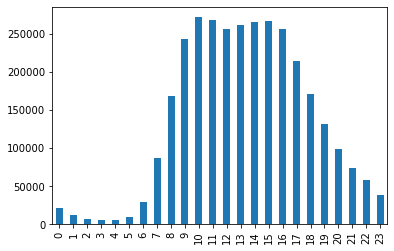

In [20]:
ax = instacart_train.order_hour_of_day.value_counts().sort_index().plot(kind='bar')
plt.show()

Es vergehen zwischen keinem bis 30 Tagen, bis die Personen im Datensatz erneut bestellt haben. Der Durchschnitt ist eine Bestellung alle 10,7 Tage. 

In [21]:
instacart_train.days_since_prior_order.value_counts().sort_index()

0.0      64436
1.0     141011
2.0     187723
3.0     210665
4.0     214488
5.0     206691
6.0     230245
7.0     306181
8.0     173259
9.0     112184
10.0     90198
11.0     76394
12.0     71356
13.0     77765
14.0     93064
15.0     61883
16.0     43423
17.0     36281
18.0     33050
19.0     31408
20.0     35173
21.0     41262
22.0     29125
23.0     21629
24.0     18704
25.0     17324
26.0     17120
27.0     19677
28.0     23833
29.0     16976
30.0    306137
Name: days_since_prior_order, dtype: int64

In [22]:
instacart_train.days_since_prior_order.mean()

10.707242248638515

Beschreibung des products Datensatzes:

Es sind fast 50.000 Produkte vorhanden, welche über 4 Spalten beschrieben werden. Der Datensatz ist vollständig, es gibt keine Null-Werte. 

In [23]:
products.shape

(49688, 4)

In [24]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


## Daten verstehen

- ToDo: Verteilungen auswerten
- ToDo: Korrellationen auswerten

- Weitere Fragestellungen
    - DOW zu Tip
    - Uhrzeit zu Tip
    - Days since prior order zu Tip
    - Order Number zu Tip
    - Departments zu Tip
    - Aisles zu Tip
    - Anzahl Produkte in der Bestellung zu Tip
    - Top Nutzer nach Tip, Neg Nutzer nach Tip
    - Products zu Tip (Top 20?, Neg 20?)

In [25]:
print(instacart_train.describe())
instacart_train.head(10)

           order_id           tip       user_id  order_number     order_dow  \
count  3.214874e+06  3.214874e+06  3.214874e+06  3.214874e+06  3.214874e+06   
mean   1.710827e+06  4.217627e-01  1.029701e+05  1.719107e+01  2.776364e+00   
std    9.875206e+05  4.938411e-01  5.953411e+04  1.779950e+01  2.041806e+00   
min    2.000000e+00  0.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00   
25%    8.556832e+05  0.000000e+00  5.138500e+04  5.000000e+00  1.000000e+00   
50%    1.711120e+06  0.000000e+00  1.026620e+05  1.100000e+01  3.000000e+00   
75%    2.566034e+06  1.000000e+00  1.543720e+05  2.400000e+01  5.000000e+00   
max    3.421083e+06  1.000000e+00  2.062090e+05  9.900000e+01  6.000000e+00   

       order_hour_of_day  days_since_prior_order  
count       3.214874e+06            3.008665e+06  
mean        1.344347e+01            1.070724e+01  
std         4.226246e+00            8.954180e+00  
min         0.000000e+00            0.000000e+00  
25%         1.000000e+01         

,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,prior,1,2,8,NaN
1,2398795,1,1,prior,2,3,7,15.0
2,473747,1,1,prior,3,3,12,21.0
3,2254736,1,1,prior,4,4,7,29.0
4,431534,1,1,prior,5,4,15,28.0
5,3367565,1,1,prior,6,2,7,19.0
6,550135,1,1,prior,7,1,9,20.0
7,3108588,1,1,prior,8,1,14,14.0
8,2295261,1,1,prior,9,1,16,0.0
9,2550362,1,1,prior,10,4,8,30.0


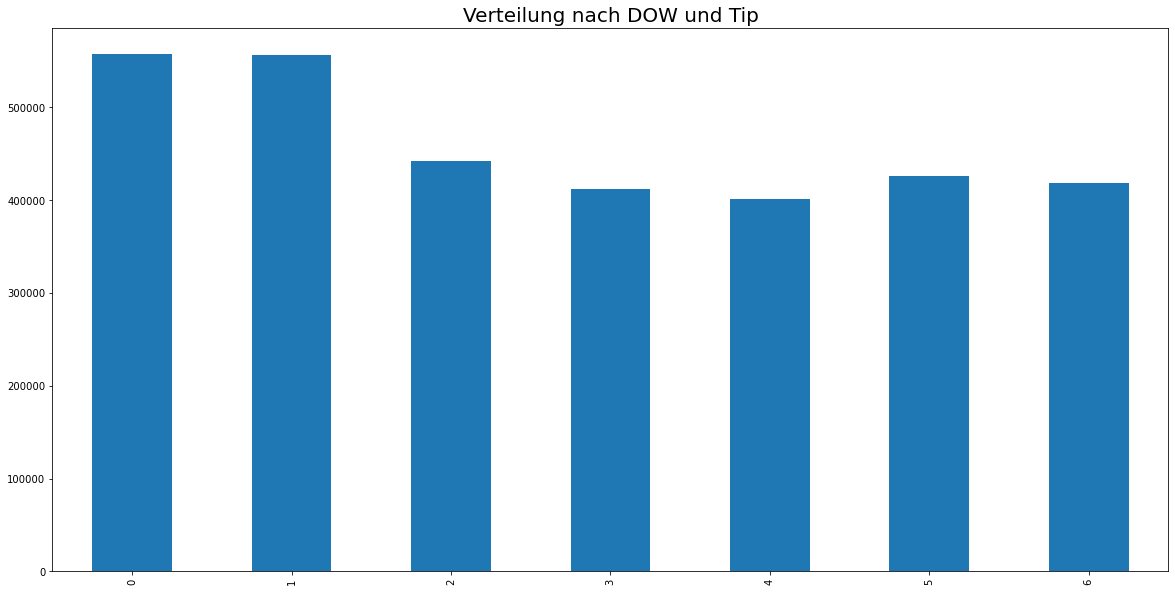

In [28]:
plt.figure(figsize=(20, 10))
ax = instacart_train['order_dow'].value_counts().sort_index().plot(kind='bar')
ax.set_title(label = 'Verteilung nach DOW und Tip', fontsize = 20)
plt.show()

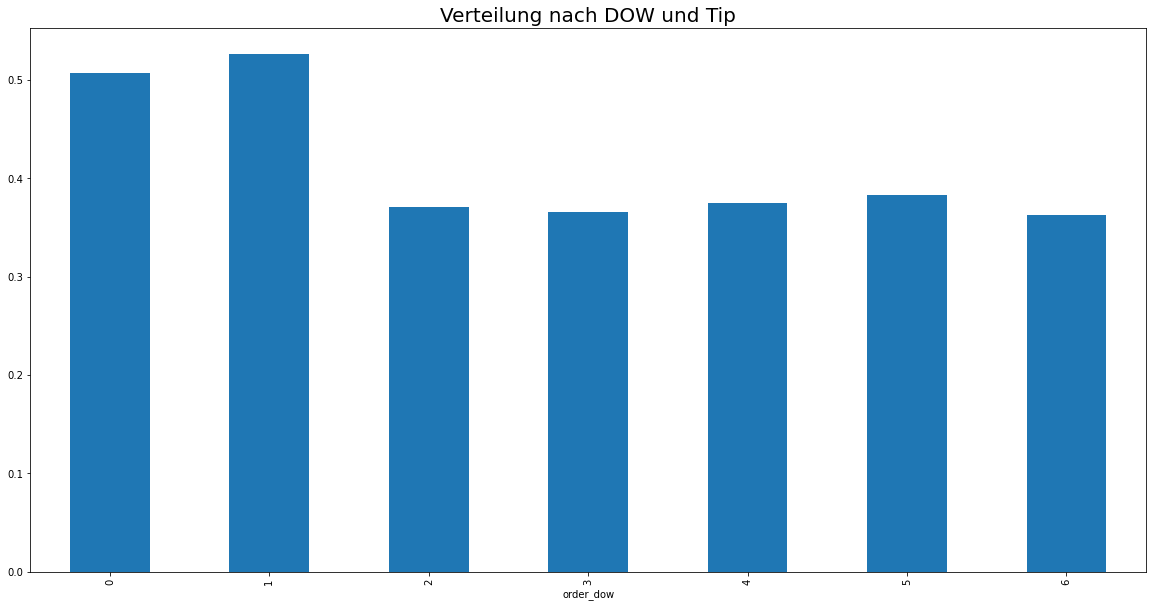

In [76]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('order_dow').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach DOW und Tip', fontsize = 20)
plt.show()

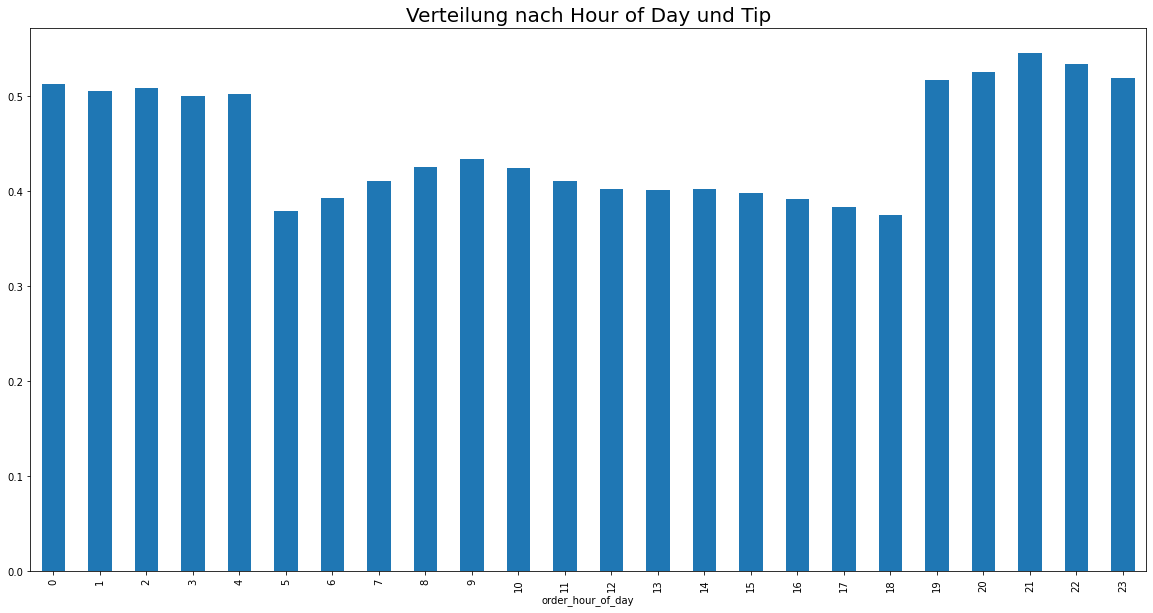

In [77]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('order_hour_of_day').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Hour of Day und Tip', fontsize = 20)
plt.show()

Verteilung nach Days since prior order

- Aufwärtstrend in der ersten Woche (1-7)
- Abwärtstrend ab Beginn der zweiten Woche

- ToDo: Diskretisierung nach Wochen untersuchen
- ToDo: Diskretisierung nach Tagen untersuchen (dsp % 7)

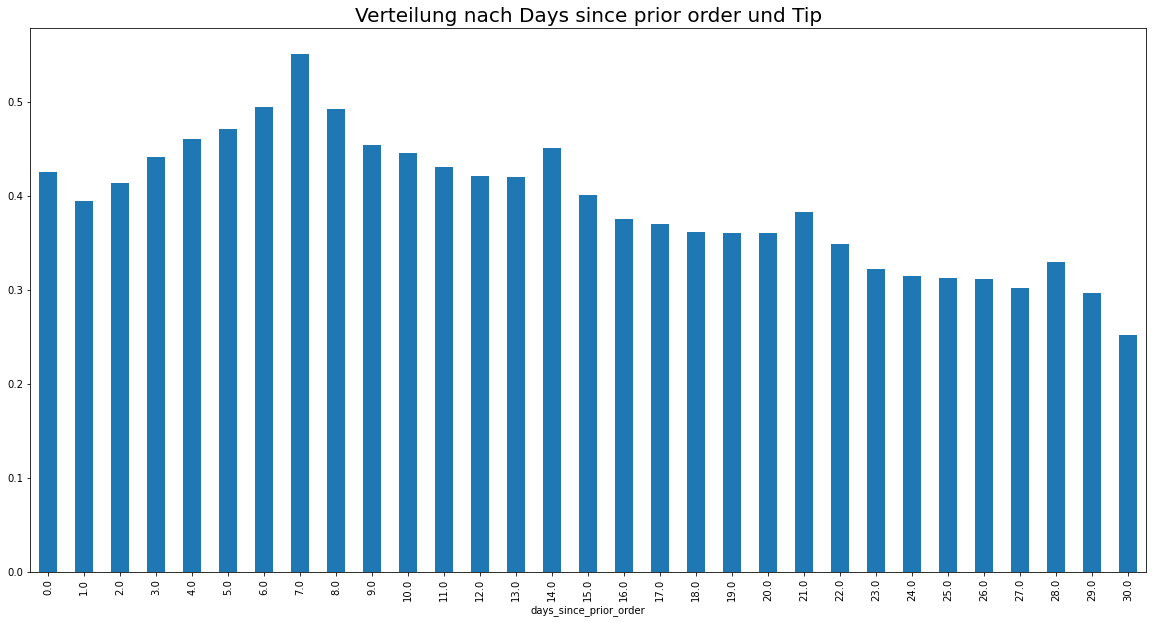

In [78]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('days_since_prior_order').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Days since prior order und Tip', fontsize = 20)
plt.show()

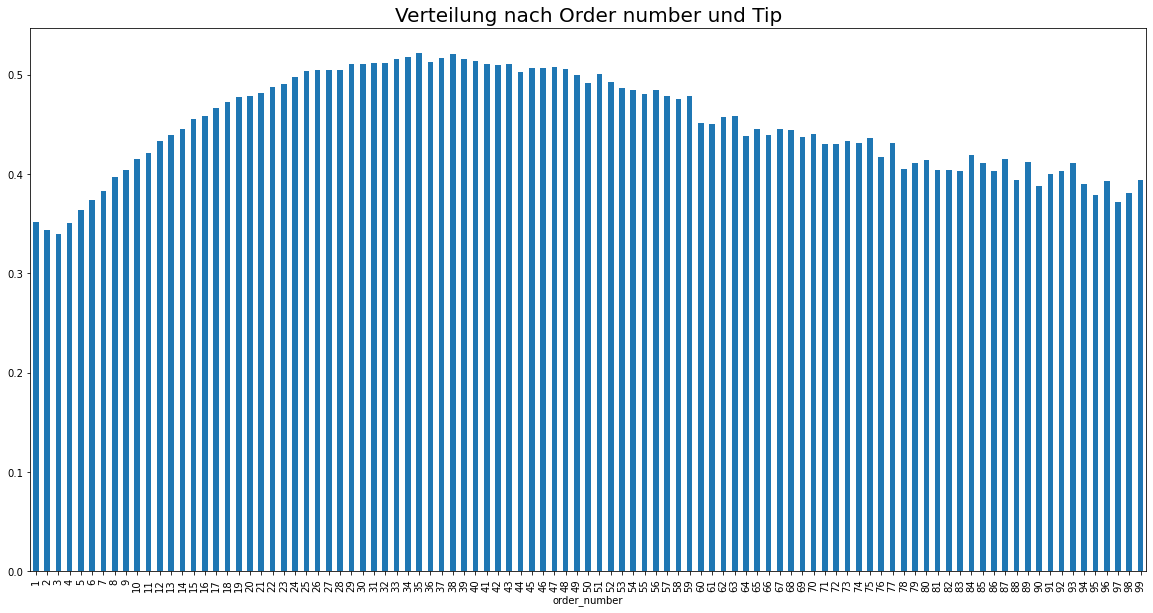

In [79]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('order_number').tip.mean().plot(kind='bar')
ax.set_title(label = 'Verteilung nach Order number und Tip', fontsize = 20)
plt.show()

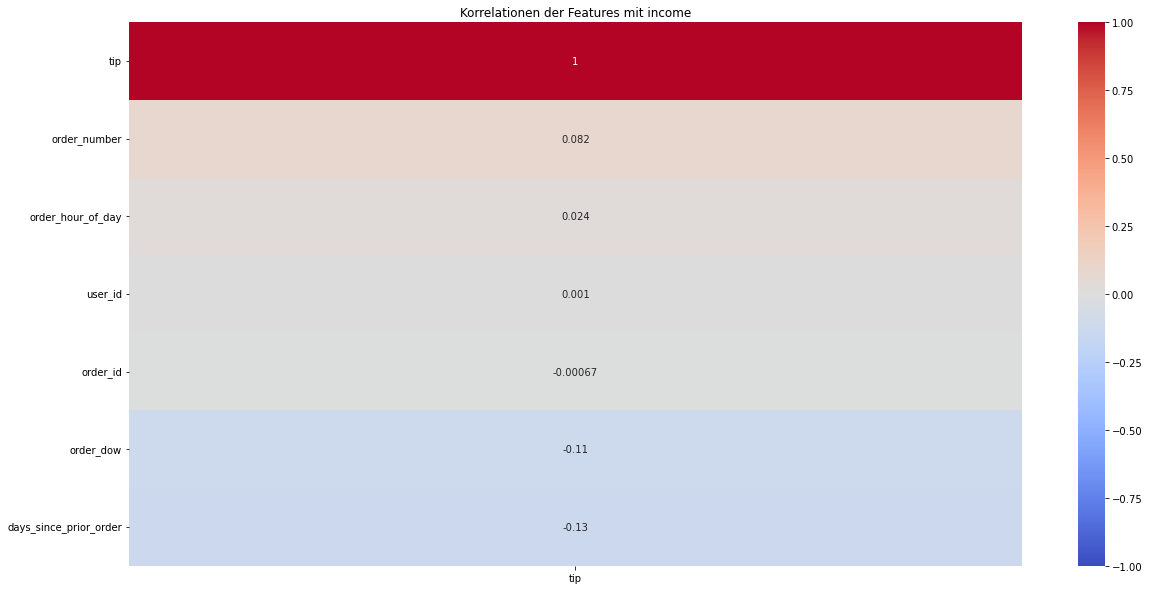

In [80]:
plt.figure(figsize=(20, 10))
corr_with_income = instacart_train.corr()[['tip']].sort_values(by='tip', ascending=False)
heatmap = sns.heatmap(corr_with_income, vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Korrelationen der Features mit income')
plt.show()

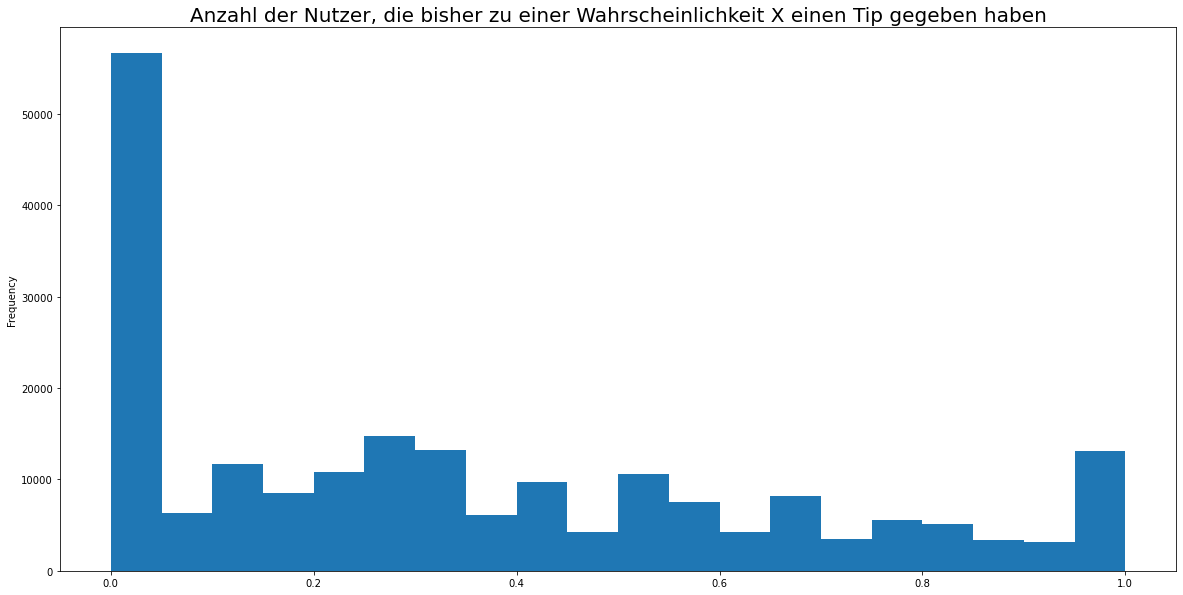

In [81]:
plt.figure(figsize=(20, 10))
ax = instacart_train.groupby('user_id').tip.mean().plot.hist(bins=20)
ax.set_title(label = 'Anzahl der Nutzer, die bisher zu einer Wahrscheinlichkeit X einen Tip gegeben haben', fontsize = 20)
plt.show()

## Datenqualität analysieren

### Outliers
- ToDo: Outlier auswerten und behandeln

### Missing Values
- ToDo: Missing values auswerten und behandeln

In [82]:
instacart_train.isna().sum()

order_id                       0
tip                            0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [83]:
instacart_train['days_since_prior_order']= instacart_train['days_since_prior_order'].fillna(instacart_train['days_since_prior_order'].mean())

In [84]:
instacart_train.isna().sum()

order_id                  0
tip                       0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

## Optimierung der Datentypen

In [85]:
''' 
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
'''
def reduce_mem_usage(train_data):
    start_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in train_data.columns:
        col_type = train_data[col].dtype
        
        if col_type not in [object]:
            c_min = train_data[col].min()
            c_max = train_data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_data[col] = train_data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_data[col] = train_data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_data[col] = train_data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_data[col] = train_data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    train_data[col] = train_data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_data[col] = train_data[col].astype(np.float32)
                else:
                    train_data[col] = train_data[col].astype(np.float64)
        else:
            train_data[col] = train_data[col].astype('category')
    end_mem = train_data.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return train_data

instacart_train = reduce_mem_usage(instacart_train)

# 

Memory usage of dataframe is 220.75 MB
Memory usage after optimization is: 70.52 MB
Decreased by 68.1%


# Data Preparation

- Feature Engineering
    - Trinkgeld bei der letzten Bestellung
    - Durchschnitt für User
    - Anzahl der Produkte pro Bestellung

- Feature Selection
    - chi2
    - f-Value
    - eval_set: Löschen, da kein Zusammenhang mit Zielvariable

- Encoding

## Feature Engineering

Create Feature: previous_order_tip mit der Information, ob der Nutzer in der vorhergehenden Bestellungen einen Tip vergeben hat.

In [86]:
instacart_train

,order_id,tip,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,1,prior,1,2,8,10.710938
1,2398795,1,1,prior,2,3,7,15.000000
2,473747,1,1,prior,3,3,12,21.000000
3,2254736,1,1,prior,4,4,7,29.000000
4,431534,1,1,prior,5,4,15,28.000000
...,...,...,...,...,...,...,...,...
3214869,2558525,0,206209,prior,9,4,15,22.000000
3214870,2266710,0,206209,prior,10,5,18,29.000000
3214871,1854736,0,206209,prior,11,4,10,30.000000
3214872,626363,1,206209,prior,12,1,12,18.000000


In [87]:
# Shift the value of column Tip per user
instacart_train['previous_order_tip'] = instacart_train.groupby('user_id')['tip'].shift(1)
instacart_train['previous_order_tip']= instacart_train['previous_order_tip'].fillna(0)

mean_tip_user

In [88]:
# Get the mean value of the user
instacart_train['mean_tip_user'] = instacart_train.groupby('user_id')['tip'].transform('mean')

something with days

In [38]:
# orders['mean_days_since_prior_oder_by_user'] = orders.groupby('user_id')['days_since_prior_order'].transform('mean')

# orders['factor'] = orders['days_since_prior_order'] / orders['mean_days_since_prior_oder_by_user']

## Feature Selection
- Delete eval_set, da es keinen logischen Zusammenhang gibt.
- Delete order_id, da es eine unique ID ist (führt zu Overfitting)
- Delete user_id, da es eine unique ID ist (führt zu Overfitting)

In [89]:
instacart_train.isnull().sum()

order_id                  0
tip                       0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
previous_order_tip        0
mean_tip_user             0
dtype: int64

In [40]:
instacart_train = instacart_train.drop(columns=['eval_set', 'order_id', 'user_id'])

# Modeling

- ToDo: Train-Test-Split (80/20)
- ToDo: Train baseline models by CV-Cross-Validation

In [41]:
instacart_train = instacart_train.sample(1000000)

In [42]:
X = instacart_train.drop(columns=['tip'])
y = instacart_train['tip']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [43]:
clf = DummyClassifier(strategy="most_frequent")
dummy_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(dummy_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (dummy_base_scores.mean(), dummy_base_scores.std()))

[0.577815 0.577815 0.577815 0.577815 0.577815]
0.58 accuracy with a standard deviation of 0.00


In [44]:
clf = KNeighborsClassifier()
knn_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(knn_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (knn_base_scores.mean(), knn_base_scores.std()))

[0.70926  0.707645 0.70721  0.70837  0.70805 ]
0.71 accuracy with a standard deviation of 0.00


In [45]:
clf = DecisionTreeClassifier()
dt_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(dt_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (dt_base_scores.mean(), dt_base_scores.std()))

[0.702645 0.70354  0.70141  0.70288  0.70262 ]
0.70 accuracy with a standard deviation of 0.00


In [46]:
clf = RandomForestClassifier(n_estimators=5)
rf_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(rf_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (rf_base_scores.mean(), rf_base_scores.std()))

[0.73748  0.737435 0.736935 0.73697  0.73667 ]
0.74 accuracy with a standard deviation of 0.00


In [47]:
clf = xgb.XGBClassifier()
xgb_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(xgb_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (xgb_base_scores.mean(), xgb_base_scores.std()))

[0.779215 0.77942  0.77878  0.778975 0.778705]
0.78 accuracy with a standard deviation of 0.00


In [48]:
clf = Perceptron()
perceptron_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(perceptron_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (perceptron_base_scores.mean(), perceptron_base_scores.std()))

[0.693295 0.60907  0.61572  0.766655 0.680545]
0.67 accuracy with a standard deviation of 0.06


In [49]:
clf = MLPClassifier(random_state=1, max_iter=20)
mlp_base_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(mlp_base_scores)
print("%0.2f accuracy with a standard deviation of %0.2f" % (mlp_base_scores.mean(), mlp_base_scores.std()))

c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jdhau\anaconda3\lib\site-packages\sklearn\neural_network\_multilaye

[0.777735 0.77801  0.776525 0.7762   0.77614 ]
0.78 accuracy with a standard deviation of 0.00


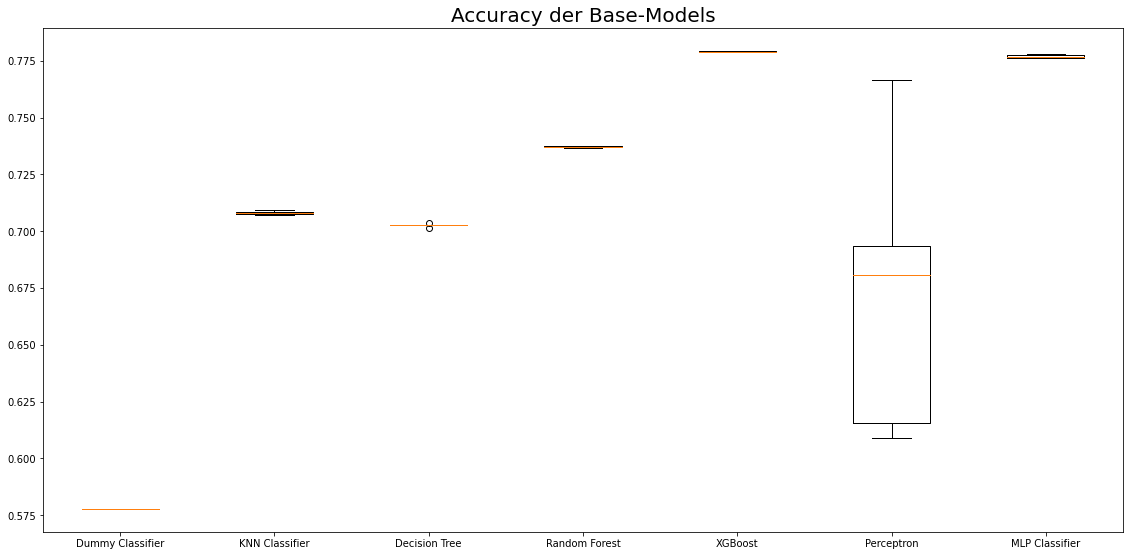

In [93]:
baseline_model = [dummy_base_scores, knn_base_scores, dt_base_scores, rf_base_scores, xgb_base_scores, perceptron_base_scores, mlp_base_scores]

fig = plt.figure(figsize =(15, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title(label = 'Accuracy der Base-Models', fontsize = 20)
 
# Creating plot
bp = ax.boxplot(baseline_model)

# rename ticks 
plt.xticks([1, 2, 3, 4, 5, 6, 7], ['Dummy Classifier', 'KNN Classifier', 'Decision Tree', 'Random Forest', 'XGBoost', 'Perceptron', 'MLP Classifier'])
# show plot
plt.show()

# Evaluation

- ToDo: Evaluation by Accuracy
- ToDo: Research Additional Metrics

## Feature Importance

### Feature importance based on Mean Decrease in Impurity

Impurits Decrease importances sind bekannt dafür, dass Sie Features mit hoher Kardinalität bevorzugen. Daher wird neber dem Mean Decrease auch die Permutation Importance betrachtet.

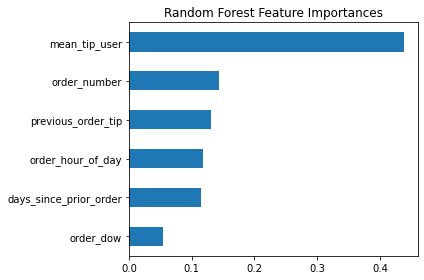

In [105]:
clf = RandomForestClassifier(n_estimators=5)
clf.fit(X_train, y_train)

mdi_importances = pd.Series(
    clf[-1].feature_importances_, index=X.columns
).sort_values(ascending=True)

ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances")
ax.figure.tight_layout()

### Feature importance based on Permutation importance

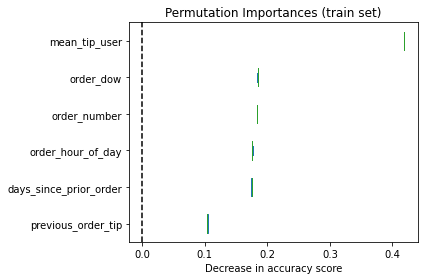

In [97]:
from sklearn.inspection import permutation_importance

clf = RandomForestClassifier(n_estimators=5)
clf.fit(X_train, y_train)

permutation_importances = permutation_importance(clf, X_train, y_train, n_repeats=5, random_state=0)

sorted_importances_idx = permutation_importances.importances_mean.argsort()
importances = pd.DataFrame(
    permutation_importances.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

# Hyperparameter